### Import libraries and Dataset


In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00


In [2]:
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 66.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [3]:
import warnings
import re
warnings.filterwarnings("ignore")
from datasets import Dataset, load_dataset, DatasetDict
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import nltk
from nltk.tokenize import word_tokenize
from torch.nn.functional import softmax
from transformers import (DistilBertTokenizer, DistilBertForSequenceClassification, AlbertTokenizer, AlbertForSequenceClassification, ElectraTokenizer, ElectraForSequenceClassification,
                         MobileBertTokenizer, MobileBertForSequenceClassification, SqueezeBertTokenizer, SqueezeBertForSequenceClassification, TrainingArguments, Trainer)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [4]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Download the dataset from drive and load dataset

In [5]:
# Load the dataset
df = pd.read_csv('paraphrase_dataset.csv')
df.head()

,sentence1,sentence2,label
0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0
1,How do I control my horny emotions?,How do you control your horniness?,1
2,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0
3,What can one do after MBBS?,What do i do after my MBBS ?,1
4,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0


In [6]:
df.describe()

,label
count,416915.000000
mean,0.380608
std,0.485537
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Data Cleaning

Handle NULL values if any

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416915 entries, 0 to 416914
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentence1  416915 non-null  object
 1   sentence2  416915 non-null  object
 2   label      416915 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.5+ MB


Handle duplicate values

In [8]:
duplicates = df.duplicated(subset=['sentence1', 'sentence2'], keep=False)

print("Duplicate Rows:")
print(df[duplicates])

Duplicate Rows:
                                                sentence1  \
364450  With the weakening of the Canadian dollar , ma...   
365015  In March 1298 , he received official Mongolian...   
365443                        July 2013 to be announced .   
365451  The specification is a method of describing te...   
365663  The LFAC was officially established in 2005 an...   
...                                                   ...   
408642  Entries marked with an asterisk are set in the...   
408804  Peter Evatt was an Olympic rower , who became ...   
409406  Entries marked with an asterisk are set in the...   
412381  Entries marked with an asterisk are set in Nod...   
412802  Peter Evatt was an Olympic rower , who became ...   

                                                sentence2  label  
364450  In November and December 2015 , with the weake...      1  
365015  He received Mongol official recognition as the...      1  
365443                announced to be created July

Remove special characters and stopwords

In [9]:

def remove_special_char(text):
    text = re.sub(r'[^A-Za-z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text.lower()

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

def preprocess_text(df):
    df['cleaned_#1'] = df['sentence1'].apply(remove_special_char)
    df['cleaned_#2'] = df['sentence2'].apply(remove_special_char)
    df['#1_tokenized'] = df['cleaned_#1'].apply(tokenize_text)
    df['#2_tokenized'] = df['cleaned_#2'].apply(tokenize_text)
    df['#1_len'] = df['#1_tokenized'].apply(len)
    df['#2_len'] = df['#2_tokenized'].apply(len)
    df['word_overlap'] = df.apply(lambda row: len(set(row['#1_tokenized']).intersection(set(row['#2_tokenized']))), axis=1)
    return df

In [10]:
preprocessed_df = preprocess_text(df)

In [11]:
preprocessed_df.head()

,sentence1,sentence2,label,cleaned_#1,cleaned_#2,#1_tokenized,#2_tokenized,#1_len,#2_len,word_overlap
0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0,how is the life of a math student could you de...,which level of prepration is enough for the ex...,"[how, is, the, life, of, a, math, student, cou...","[which, level, of, prepration, is, enough, for...",14,10,3
1,How do I control my horny emotions?,How do you control your horniness?,1,how do i control my horny emotions,how do you control your horniness,"[how, do, i, control, my, horny, emotions]","[how, do, you, control, your, horniness]",7,6,3
2,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0,what causes stool color to change to yellow,what can cause stool to come out as little balls,"[what, causes, stool, color, to, change, to, y...","[what, can, cause, stool, to, come, out, as, l...",8,10,3
3,What can one do after MBBS?,What do i do after my MBBS ?,1,what can one do after mbbs,what do i do after my mbbs,"[what, can, one, do, after, mbbs]","[what, do, i, do, after, my, mbbs]",6,7,4
4,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0,where can i find a power outlet for my laptop ...,would a second airport in sydney australia be ...,"[where, can, i, find, a, power, outlet, for, m...","[would, a, second, airport, in, sydney, austra...",13,21,3


### Data Visualization

In [12]:
label_counts = df['label'].value_counts()
label_counts

label
0    258234
1    158681
Name: count, dtype: int64

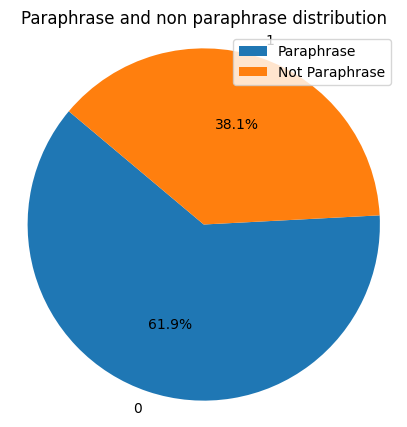

In [13]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Paraphrase and non paraphrase distribution')
plt.legend(['Paraphrase', 'Not Paraphrase'])
plt.axis('equal')
plt.show()

### Data Preprocessing and preparation

In [14]:
# Sample a fraction of the dataset (20% in this case)
fraction = 0.10
df = df.sample(frac=fraction, random_state=42)
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

# Convert DataFrame to Hugging Face dataset format
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)

datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

In [15]:
# Initialize tokenizers and models
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

mobilebert_tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

squeezebert_tokenizer = SqueezeBertTokenizer.from_pretrained('squeezebert/squeezebert-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/500 [00:00<?, ?B/s]

In [16]:
def tokenize_function(example, tokenizer):
    return tokenizer(example['sentence1'], example['sentence2'], truncation="longest_first", padding="max_length", max_length=512)

distilbert_tokenized_datasets = datasets.map(lambda examples: tokenize_function(examples, distilbert_tokenizer), batched=True)
albert_tokenized_datasets = datasets.map(lambda examples: tokenize_function(examples, albert_tokenizer), batched=True)
electra_tokenized_datasets = datasets.map(lambda examples: tokenize_function(examples, electra_tokenizer), batched=True)
mobilebert_tokenized_datasets = datasets.map(lambda examples: tokenize_function(examples, mobilebert_tokenizer), batched=True)
squeezebert_tokenized_datasets = datasets.map(lambda examples: tokenize_function(examples, squeezebert_tokenizer), batched=True)

Map:   0%|          | 0/37522 [00:00<?, ? examples/s]

Map:   0%|          | 0/4170 [00:00<?, ? examples/s]

Map:   0%|          | 0/37522 [00:00<?, ? examples/s]

Map:   0%|          | 0/4170 [00:00<?, ? examples/s]

Map:   0%|          | 0/37522 [00:00<?, ? examples/s]

Map:   0%|          | 0/4170 [00:00<?, ? examples/s]

Map:   0%|          | 0/37522 [00:00<?, ? examples/s]

Map:   0%|          | 0/4170 [00:00<?, ? examples/s]

Map:   0%|          | 0/37522 [00:00<?, ? examples/s]

Map:   0%|          | 0/4170 [00:00<?, ? examples/s]

### Model Training and Fine tuning

In [17]:
distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
electra_model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)
mobilebert_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=2)
squeezebert_model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pytorch_model.bin:   0%|          | 0.00/103M [00:00<?, ?B/s]

Some weights of SqueezeBertForSequenceClassification were not initialized from the model checkpoint at squeezebert/squeezebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
)

Distil-BERT model

In [ ]:
distilbert_trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=distilbert_tokenized_datasets['train'],
    eval_dataset=distilbert_tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)

distilbert_trainer.train()

In [ ]:
# Save just the model weights.
distilbert_model_path = "./distilbert-model-weights"
distilbert_model.save_pretrained(distilbert_model_path)

# Optionally, save the tokenizer as well, to reload the model later for inference
distilbert_tokenizer.save_pretrained(distilbert_model_path)

('./saved_model_weights/tokenizer_config.json',
 './saved_model_weights/special_tokens_map.json',
 './saved_model_weights/vocab.txt',
 './saved_model_weights/added_tokens.json')

Albert model

In [ ]:
albert_trainer = Trainer(
    model=albert_model,
    args=training_args,
    train_dataset=albert_tokenized_datasets['train'],
    eval_dataset=albert_tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)

albert_trainer.train()

In [ ]:
# Save just the model weights.
albert_model_path = "./albert-model-weights"
albert_model.save_pretrained(albert_model_path)

# Optionally, save the tokenizer as well, to reload the model later for inference
albert_tokenizer.save_pretrained(albert_model_path)

Electra model

In [ ]:
electra_trainer = Trainer(
    model=electra_model,
    args=training_args,
    train_dataset=electra_tokenized_datasets['train'],
    eval_dataset=electra_tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)

electra_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.277600,0.494674,0.822782,0.765173,0.728814,0.805351
2,0.329700,0.432207,0.822302,0.769804,0.718677,0.828763
3,0.282100,0.442677,0.826139,0.773225,0.726204,0.826756


TrainOutput(global_step=7038, training_loss=0.30560304184263487, metrics={'train_runtime': 2087.363, 'train_samples_per_second': 53.927, 'train_steps_per_second': 3.372, 'total_flos': 3311651289894912.0, 'train_loss': 0.30560304184263487, 'epoch': 3.0})

In [ ]:
# Save just the model weights.
electra_model_path = "./electra-model-weights"
electra_model.save_pretrained(electra_model_path)

# Optionally, save the tokenizer as well, to reload the model later for inference
electra_tokenizer.save_pretrained(electra_model_path)

('./electra-model-weights/tokenizer_config.json',
 './electra-model-weights/special_tokens_map.json',
 './electra-model-weights/vocab.txt',
 './electra-model-weights/added_tokens.json')

Mobile-BERT

In [ ]:
mobilebert_trainer = Trainer(
    model=mobilebert_model,
    args=training_args,
    train_dataset=mobilebert_tokenized_datasets['train'],
    eval_dataset=mobilebert_tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)

mobilebert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.417500,0.399673,0.802878,0.708924,0.753198,0.669565
2,0.360900,0.384766,0.814628,0.741039,0.742282,0.739799
3,0.338700,0.387360,0.809353,0.755159,0.699772,0.820067


TrainOutput(global_step=7038, training_loss=962.7053429497071, metrics={'train_runtime': 4765.7245, 'train_samples_per_second': 23.62, 'train_steps_per_second': 1.477, 'total_flos': 7058847370383360.0, 'train_loss': 962.7053429497071, 'epoch': 3.0})

In [ ]:
# Save just the model weights.
mobilebert_model_path = "./mobilebert-model-weights"
mobilebert_model.save_pretrained(mobilebert_model_path)

# Optionally, save the tokenizer as well, to reload the model later for inference
mobilebert_tokenizer.save_pretrained(mobilebert_model_path)

('./mobilebert-model-weights/tokenizer_config.json',
 './mobilebert-model-weights/special_tokens_map.json',
 './mobilebert-model-weights/vocab.txt',
 './mobilebert-model-weights/added_tokens.json')

Squeeze BERT

In [ ]:
squeezebert_trainer = Trainer(
    model=squeezebert_model,
    args=training_args,
    train_dataset=squeezebert_tokenized_datasets['train'],
    eval_dataset=squeezebert_tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)

squeezebert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.393000,0.392725,0.810072,0.747610,0.713938,0.784615
2,0.358800,0.393056,0.829736,0.774889,0.736588,0.817391


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.393000,0.392725,0.810072,0.747610,0.713938,0.784615
2,0.358800,0.393056,0.829736,0.774889,0.736588,0.817391
3,0.335700,0.401482,0.834532,0.786113,0.732525,0.848161


TrainOutput(global_step=7038, training_loss=0.3689072376694588, metrics={'train_runtime': 7362.299, 'train_samples_per_second': 15.29, 'train_steps_per_second': 0.956, 'total_flos': 9425045580484608.0, 'train_loss': 0.3689072376694588, 'epoch': 3.0})

In [ ]:
# Save just the model weights.
squeezebert_model_path = "./squeezebert-model-weights"
squeezebert_model.save_pretrained(squeezebert_model_path)
# Optionally, save the tokenizer as well, to reload the model later for inference
squeezebert_tokenizer.save_pretrained(squeezebert_model_path)

('./squeezebert-model-weights/tokenizer_config.json',
 './squeezebert-model-weights/special_tokens_map.json',
 './squeezebert-model-weights/vocab.txt',
 './squeezebert-model-weights/added_tokens.json')

### Model Evaluation and Inference

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.nn.functional import cross_entropy

In [ ]:
dataset = load_dataset("glue", "mrpc")
test_dataset = dataset['test']

test_loader = DataLoader(test_dataset, batch_size=16)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

def evaluate_model(model, tokenizer, test_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, collate_fn=data_collator)

    total = 0
    correct = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == batch['labels'].to(device)).sum().item()
            total += batch['labels'].size(0)

    return correct / total

In [ ]:
models = {
    "distilbert": "./distilbert-model-weights",
    "mobilebert": "./mobilebert-model-weights",
    "electra": "./electra-model-weights"
}

results = {}
for name, model_path in models.items():
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    test_loader = test_dataset.map(lambda examples: tokenize_function(examples, tokenizer), batched=True)
    results[name] = evaluate_model(model, tokenizer, test_loader)
    print(f"{name} - Loss: {results[name]['loss']:.3f}, Accuracy: {results[name]['accuracy']:.3f}, F1 Score: {results[name]['f1_score']:.3f}")


Model inference

In [ ]:
# Assuming tokenizer is already loaded
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define the sentence pair
sentence1 = "It is raining heavily today."
sentence2 = "The weather is sunny today."

# Tokenize the sentence pair
inputs = tokenizer(sentence1, sentence2, return_tensors="pt", padding=True, truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Load the model
model = DistilBertForSequenceClassification.from_pretrained('./distilbert-model-weights')
model.eval()  # Set the model to evaluation mode

# Check if GPU is available and move model and inputs accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform prediction
with torch.no_grad():  # Disable gradient calculation
    outputs = model(**inputs)
    logits = outputs.logits

# Calculate probabilities
probabilities = softmax(logits, dim=1)

# Get the index of the highest probability to determine the predicted class
predicted_class = torch.argmax(probabilities, dim=1)
is_paraphrase = (predicted_class == 1).item()  # Use .item() to extract a Python boolean
print(f"Sentences are: ({sentence1}, {sentence2})")
print(f"The sentences are {'paraphrases' if is_paraphrase else 'not paraphrases'}")


Sentences are: (It is raining heavily today., The weather is sunny today.)
The sentences are not paraphrases


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def load_model_and_tokenizer(model_dir):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model.eval()  # Set the model to evaluation mode
    return tokenizer, model

def predict_paraphrase(model, tokenizer, sentence1, sentence2):
    # Encode the sentences
    inputs = tokenizer.encode_plus(sentence1, sentence2, return_tensors="pt", max_length=128, truncation=True, padding="max_length")

    # Move to the same device as model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    return probabilities[:, 1].item()  # Probability of being a paraphrase

# Define your model directories
model_dirs = {
    'DistilBERT': 'distilbert-model-weights',
    'ALBERT': 'albert-model-weights',
    'MobileBERT': 'mobilebert-model-weights',
    'ELECTRA': 'electra-model-weights',
    'SQEEZEBERT': 'sqeezebert-model-weights'
}

# Example sentences
sentence1 = "What day is today?"
sentence2 = "What is today's date?"

# Load models and make predictions
results = {}
for model_name, model_dir in model_dirs.items():
    tokenizer, model = load_model_and_tokenizer(model_dir)
    prob = predict_paraphrase(model, tokenizer, sentence1, sentence2)
    results[model_name] = f"{prob:.2f}"

# Print the results
for model_name, result in results.items():
    print(f"{model_name} thinks that the probability of the sentences being paraphrases is: {result}")

DistilBERT thinks that the probability of the sentences being paraphrases is: 0.98
ALBERT thinks that the probability of the sentences being paraphrases is: 0.93
MobileBERT thinks that the probability of the sentences being paraphrases is: 0.70
ELECTRA thinks that the probability of the sentences being paraphrases is: 0.90
SQEEZEBERT thinks that the probability of the sentences being paraphrases is: 0.93
